In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import sys
import numpy as np
import torch.nn as nn

In [3]:
print(sys.version)
print(torch.cuda.get_device_name(0))

3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
GeForce GTX 1660


In [25]:
def data_loader(batch):
#     transform = transforms.Compose(
#         [transforms.ToTensor(),
#          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # Normalize(平均, 偏差)

#     trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                             download=True, transform=transform)
#     trainloader = torch.utils.data.DataLoader(trainset, batch_size,
#                                               shuffle=True, num_workers=2)

#     testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                            download=True, transform=transform)
#     testloader = torch.utils.data.DataLoader(testset, batch_size,
#                                              shuffle=False, num_workers=2)

    trainloader = DataLoader(
        datasets.CIFAR10('./data',
                         train=True,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                [0.5, 0.5, 0.5],  # RGB 平均
                                [0.5, 0.5, 0.5]   # RGB 標準偏差
                                )
                         ])),
        batch_size=batch,
        shuffle=True
    )
 
    testloader = DataLoader(
        datasets.CIFAR10('./data',
                         train=False,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                 [0.5, 0.5, 0.5],  # RGB 平均
                                 [0.5, 0.5, 0.5]  # RGB 標準偏差
                             )
                         ])),
        batch_size=batch,
        shuffle=True
    )
    return trainloader, testloader

In [26]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [27]:
%matplotlib inline

Files already downloaded and verified
Files already downloaded and verified
<class 'torch.utils.data.dataloader.DataLoader'>


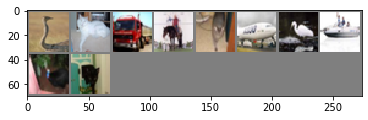

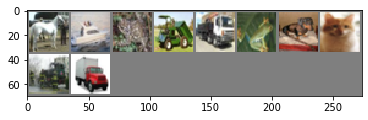

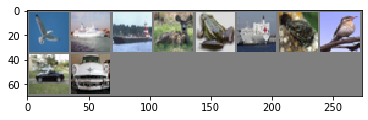

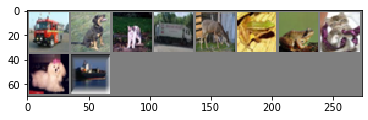

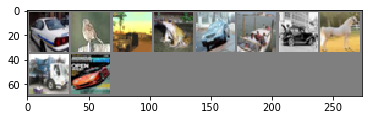

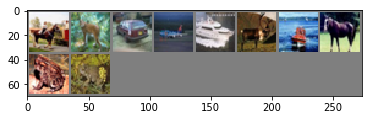

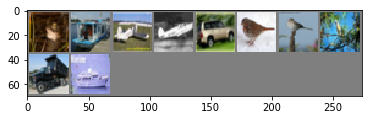

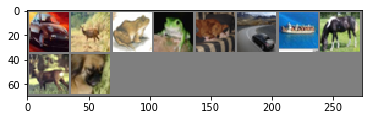

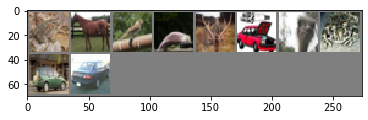

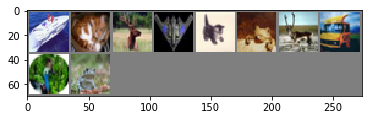

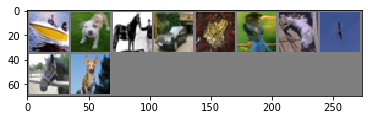

In [28]:
trainloader, testloader = data_loader(10)
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 画像の表示
print(type(trainloader))
for i, (images, label) in enumerate(testloader):
    imshow(torchvision.utils.make_grid(images))
    if i == 10:
        break

In [29]:
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3,  # チャネル入力
                                     6,  # チャンネル出力
                                     5,  # カーネルサイズ
                                     1,  # ストライド (デフォルトは1)
                                     0,  # パディング (デフォルトは0)
                                     )
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
 
        self.pool = torch.nn.MaxPool2d(2, 2)  # カーネルサイズ, ストライド
 
        self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)  # 入力サイズ, 出力サイズ
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)
 
    def forward(self, x):
        x = f.relu(self.conv1(x))
        x = self.pool(x)
        x = f.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)  # 1次元データに変えて全結合層へ
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x)
 
        return x

In [30]:
history = {
    'train_loss':[],
    'test_loss':[],
    'test_acc':[]
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = myCNN().to(device)

In [31]:
batch_size = 64
num_epoch = 100

In [32]:
trainloader, testloader = data_loader(batch_size)
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


In [33]:
for i_epoch in range(num_epoch):
    loss = None
    net.train(True)
    
    for i, (data, target) in enumerate(trainloader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
                print('Training log: {} epoch ({} / 60000 train. data). Loss: {}'.format(i_epoch+1, (i+1)*batch_size, loss.item()))
    
    history['train_loss'].append(loss)
    
    net.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in testloader:
            data = data.to(device)
            target = target.to(device)
            
            output = net(data)
            test_loss += f.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= 10000
    print('Test loss (avg): {}, Accuracy: {}'.format(test_loss, correct / 10000))
    
    history['test_loss'].append(test_loss)
    history['test_acc'].append(correct / 10000)

Training log: 1 epoch (64 / 60000 train. data). Loss: 2.3035402297973633
Training log: 1 epoch (704 / 60000 train. data). Loss: 2.3103647232055664
Training log: 1 epoch (1344 / 60000 train. data). Loss: 2.225034475326538
Training log: 1 epoch (1984 / 60000 train. data). Loss: 2.086684226989746
Training log: 1 epoch (2624 / 60000 train. data). Loss: 2.0769670009613037
Training log: 1 epoch (3264 / 60000 train. data). Loss: 1.9672218561172485
Training log: 1 epoch (3904 / 60000 train. data). Loss: 2.0916242599487305
Training log: 1 epoch (4544 / 60000 train. data). Loss: 1.9780185222625732
Training log: 1 epoch (5184 / 60000 train. data). Loss: 1.9345707893371582
Training log: 1 epoch (5824 / 60000 train. data). Loss: 1.9217811822891235
Training log: 1 epoch (6464 / 60000 train. data). Loss: 1.8844997882843018
Training log: 1 epoch (7104 / 60000 train. data). Loss: 2.0059385299682617
Training log: 1 epoch (7744 / 60000 train. data). Loss: 1.7491496801376343
Training log: 1 epoch (8384 / 

Training log: 2 epoch (18624 / 60000 train. data). Loss: 1.4514806270599365
Training log: 2 epoch (19264 / 60000 train. data). Loss: 1.3401658535003662
Training log: 2 epoch (19904 / 60000 train. data). Loss: 1.3486093282699585
Training log: 2 epoch (20544 / 60000 train. data). Loss: 1.387182593345642
Training log: 2 epoch (21184 / 60000 train. data). Loss: 1.5125216245651245
Training log: 2 epoch (21824 / 60000 train. data). Loss: 1.4050612449645996
Training log: 2 epoch (22464 / 60000 train. data). Loss: 1.3582308292388916
Training log: 2 epoch (23104 / 60000 train. data). Loss: 1.3289952278137207
Training log: 2 epoch (23744 / 60000 train. data). Loss: 1.2524583339691162
Training log: 2 epoch (24384 / 60000 train. data). Loss: 1.485921025276184
Training log: 2 epoch (25024 / 60000 train. data). Loss: 1.2595432996749878
Training log: 2 epoch (25664 / 60000 train. data). Loss: 1.2830047607421875
Training log: 2 epoch (26304 / 60000 train. data). Loss: 1.5329712629318237
Training log: 

Training log: 3 epoch (37184 / 60000 train. data). Loss: 1.334013819694519
Training log: 3 epoch (37824 / 60000 train. data). Loss: 1.2098006010055542
Training log: 3 epoch (38464 / 60000 train. data). Loss: 1.316489338874817
Training log: 3 epoch (39104 / 60000 train. data). Loss: 1.0694599151611328
Training log: 3 epoch (39744 / 60000 train. data). Loss: 1.0224392414093018
Training log: 3 epoch (40384 / 60000 train. data). Loss: 1.214835524559021
Training log: 3 epoch (41024 / 60000 train. data). Loss: 1.293531894683838
Training log: 3 epoch (41664 / 60000 train. data). Loss: 0.9015356302261353
Training log: 3 epoch (42304 / 60000 train. data). Loss: 1.1714640855789185
Training log: 3 epoch (42944 / 60000 train. data). Loss: 1.1083509922027588
Training log: 3 epoch (43584 / 60000 train. data). Loss: 1.021950602531433
Training log: 3 epoch (44224 / 60000 train. data). Loss: 1.0822632312774658
Training log: 3 epoch (44864 / 60000 train. data). Loss: 0.9547255635261536
Training log: 3 e

Training log: 5 epoch (5184 / 60000 train. data). Loss: 1.0519092082977295
Training log: 5 epoch (5824 / 60000 train. data). Loss: 1.0755083560943604
Training log: 5 epoch (6464 / 60000 train. data). Loss: 0.9400948882102966
Training log: 5 epoch (7104 / 60000 train. data). Loss: 0.9549370408058167
Training log: 5 epoch (7744 / 60000 train. data). Loss: 1.1781049966812134
Training log: 5 epoch (8384 / 60000 train. data). Loss: 1.243935227394104
Training log: 5 epoch (9024 / 60000 train. data). Loss: 0.874574601650238
Training log: 5 epoch (9664 / 60000 train. data). Loss: 1.1169414520263672
Training log: 5 epoch (10304 / 60000 train. data). Loss: 1.1042405366897583
Training log: 5 epoch (10944 / 60000 train. data). Loss: 1.16118586063385
Training log: 5 epoch (11584 / 60000 train. data). Loss: 0.9539800882339478
Training log: 5 epoch (12224 / 60000 train. data). Loss: 1.2401193380355835
Training log: 5 epoch (12864 / 60000 train. data). Loss: 1.2012333869934082
Training log: 5 epoch (1

Training log: 6 epoch (24384 / 60000 train. data). Loss: 1.2910653352737427
Training log: 6 epoch (25024 / 60000 train. data). Loss: 0.9608007669448853
Training log: 6 epoch (25664 / 60000 train. data). Loss: 1.0685997009277344
Training log: 6 epoch (26304 / 60000 train. data). Loss: 0.9119829535484314
Training log: 6 epoch (26944 / 60000 train. data). Loss: 0.6939762830734253
Training log: 6 epoch (27584 / 60000 train. data). Loss: 0.988202691078186
Training log: 6 epoch (28224 / 60000 train. data). Loss: 1.0517692565917969
Training log: 6 epoch (28864 / 60000 train. data). Loss: 1.1242530345916748
Training log: 6 epoch (29504 / 60000 train. data). Loss: 1.1582812070846558
Training log: 6 epoch (30144 / 60000 train. data). Loss: 0.9112817049026489
Training log: 6 epoch (30784 / 60000 train. data). Loss: 0.8793402314186096
Training log: 6 epoch (31424 / 60000 train. data). Loss: 1.0770573616027832
Training log: 6 epoch (32064 / 60000 train. data). Loss: 1.101618766784668
Training log: 

Training log: 7 epoch (43584 / 60000 train. data). Loss: 0.8838896155357361
Training log: 7 epoch (44224 / 60000 train. data). Loss: 1.0901641845703125
Training log: 7 epoch (44864 / 60000 train. data). Loss: 0.9225552082061768
Training log: 7 epoch (45504 / 60000 train. data). Loss: 1.0919874906539917
Training log: 7 epoch (46144 / 60000 train. data). Loss: 1.105590581893921
Training log: 7 epoch (46784 / 60000 train. data). Loss: 0.930605411529541
Training log: 7 epoch (47424 / 60000 train. data). Loss: 1.0066691637039185
Training log: 7 epoch (48064 / 60000 train. data). Loss: 0.8795101642608643
Training log: 7 epoch (48704 / 60000 train. data). Loss: 0.8785955905914307
Training log: 7 epoch (49344 / 60000 train. data). Loss: 0.916597843170166
Training log: 7 epoch (49984 / 60000 train. data). Loss: 1.1412100791931152
Test loss (avg): -2.664088182067871, Accuracy: 0.6253
Training log: 8 epoch (64 / 60000 train. data). Loss: 1.0022435188293457
Training log: 8 epoch (704 / 60000 train

Training log: 9 epoch (11584 / 60000 train. data). Loss: 1.1188725233078003
Training log: 9 epoch (12224 / 60000 train. data). Loss: 0.9472660422325134
Training log: 9 epoch (12864 / 60000 train. data). Loss: 0.9300259947776794
Training log: 9 epoch (13504 / 60000 train. data). Loss: 0.7836766839027405
Training log: 9 epoch (14144 / 60000 train. data). Loss: 0.9146939516067505
Training log: 9 epoch (14784 / 60000 train. data). Loss: 0.9076963663101196
Training log: 9 epoch (15424 / 60000 train. data). Loss: 1.0687516927719116
Training log: 9 epoch (16064 / 60000 train. data). Loss: 0.8049198985099792
Training log: 9 epoch (16704 / 60000 train. data). Loss: 1.0091439485549927
Training log: 9 epoch (17344 / 60000 train. data). Loss: 0.9545390009880066
Training log: 9 epoch (17984 / 60000 train. data). Loss: 0.7080659866333008
Training log: 9 epoch (18624 / 60000 train. data). Loss: 0.8309858441352844
Training log: 9 epoch (19264 / 60000 train. data). Loss: 0.8860132098197937
Training log

Training log: 10 epoch (30784 / 60000 train. data). Loss: 1.0213451385498047
Training log: 10 epoch (31424 / 60000 train. data). Loss: 0.8199073076248169
Training log: 10 epoch (32064 / 60000 train. data). Loss: 0.8613731861114502
Training log: 10 epoch (32704 / 60000 train. data). Loss: 0.9761675000190735
Training log: 10 epoch (33344 / 60000 train. data). Loss: 1.023787260055542
Training log: 10 epoch (33984 / 60000 train. data). Loss: 1.0351588726043701
Training log: 10 epoch (34624 / 60000 train. data). Loss: 0.8449811935424805
Training log: 10 epoch (35264 / 60000 train. data). Loss: 0.8766791224479675
Training log: 10 epoch (35904 / 60000 train. data). Loss: 1.1848224401474
Training log: 10 epoch (36544 / 60000 train. data). Loss: 0.9556152820587158
Training log: 10 epoch (37184 / 60000 train. data). Loss: 0.8014822602272034
Training log: 10 epoch (37824 / 60000 train. data). Loss: 0.90743088722229
Training log: 10 epoch (38464 / 60000 train. data). Loss: 0.9138593077659607
Train

Training log: 11 epoch (48704 / 60000 train. data). Loss: 0.8144521117210388
Training log: 11 epoch (49344 / 60000 train. data). Loss: 0.7663305997848511
Training log: 11 epoch (49984 / 60000 train. data). Loss: 0.6508083343505859
Test loss (avg): -3.052891511154175, Accuracy: 0.6391
Training log: 12 epoch (64 / 60000 train. data). Loss: 0.8631391525268555
Training log: 12 epoch (704 / 60000 train. data). Loss: 0.6488791704177856
Training log: 12 epoch (1344 / 60000 train. data). Loss: 0.8091844916343689
Training log: 12 epoch (1984 / 60000 train. data). Loss: 0.9201346635818481
Training log: 12 epoch (2624 / 60000 train. data). Loss: 0.6948240995407104
Training log: 12 epoch (3264 / 60000 train. data). Loss: 0.7334517240524292
Training log: 12 epoch (3904 / 60000 train. data). Loss: 0.7190753221511841
Training log: 12 epoch (4544 / 60000 train. data). Loss: 0.6981801390647888
Training log: 12 epoch (5184 / 60000 train. data). Loss: 0.7737249135971069
Training log: 12 epoch (5824 / 600

Training log: 13 epoch (15424 / 60000 train. data). Loss: 0.8747603297233582
Training log: 13 epoch (16064 / 60000 train. data). Loss: 0.5909057259559631
Training log: 13 epoch (16704 / 60000 train. data). Loss: 0.6810715198516846
Training log: 13 epoch (17344 / 60000 train. data). Loss: 0.6043018102645874
Training log: 13 epoch (17984 / 60000 train. data). Loss: 0.8013395071029663
Training log: 13 epoch (18624 / 60000 train. data). Loss: 0.7158408761024475
Training log: 13 epoch (19264 / 60000 train. data). Loss: 0.7510761022567749
Training log: 13 epoch (19904 / 60000 train. data). Loss: 0.7473149299621582
Training log: 13 epoch (20544 / 60000 train. data). Loss: 0.5581878423690796
Training log: 13 epoch (21184 / 60000 train. data). Loss: 0.7355228662490845
Training log: 13 epoch (21824 / 60000 train. data). Loss: 0.9213376045227051
Training log: 13 epoch (22464 / 60000 train. data). Loss: 0.7479496002197266
Training log: 13 epoch (23104 / 60000 train. data). Loss: 0.628919243812561


Training log: 14 epoch (33344 / 60000 train. data). Loss: 0.727268636226654
Training log: 14 epoch (33984 / 60000 train. data). Loss: 0.9119665622711182
Training log: 14 epoch (34624 / 60000 train. data). Loss: 0.7259706258773804
Training log: 14 epoch (35264 / 60000 train. data). Loss: 0.7157326936721802
Training log: 14 epoch (35904 / 60000 train. data). Loss: 0.6879248023033142
Training log: 14 epoch (36544 / 60000 train. data). Loss: 0.6529372334480286
Training log: 14 epoch (37184 / 60000 train. data). Loss: 0.7737053632736206
Training log: 14 epoch (37824 / 60000 train. data). Loss: 0.7987939715385437
Training log: 14 epoch (38464 / 60000 train. data). Loss: 0.6049408316612244
Training log: 14 epoch (39104 / 60000 train. data). Loss: 0.8409508466720581
Training log: 14 epoch (39744 / 60000 train. data). Loss: 0.9145087599754333
Training log: 14 epoch (40384 / 60000 train. data). Loss: 0.637849748134613
Training log: 14 epoch (41024 / 60000 train. data). Loss: 0.7975209951400757
T

Training log: 16 epoch (1344 / 60000 train. data). Loss: 0.48054125905036926
Training log: 16 epoch (1984 / 60000 train. data). Loss: 0.6270567774772644
Training log: 16 epoch (2624 / 60000 train. data). Loss: 0.8056437969207764
Training log: 16 epoch (3264 / 60000 train. data). Loss: 0.7324612736701965
Training log: 16 epoch (3904 / 60000 train. data). Loss: 0.5470237135887146
Training log: 16 epoch (4544 / 60000 train. data). Loss: 0.9107528924942017
Training log: 16 epoch (5184 / 60000 train. data). Loss: 0.7054854035377502
Training log: 16 epoch (5824 / 60000 train. data). Loss: 0.8775448203086853
Training log: 16 epoch (6464 / 60000 train. data). Loss: 0.8946155309677124
Training log: 16 epoch (7104 / 60000 train. data). Loss: 0.8089279532432556
Training log: 16 epoch (7744 / 60000 train. data). Loss: 0.674918532371521
Training log: 16 epoch (8384 / 60000 train. data). Loss: 0.7913963794708252
Training log: 16 epoch (9024 / 60000 train. data). Loss: 0.5828107595443726
Training log

Training log: 17 epoch (19264 / 60000 train. data). Loss: 0.6806391477584839
Training log: 17 epoch (19904 / 60000 train. data). Loss: 0.6345885992050171
Training log: 17 epoch (20544 / 60000 train. data). Loss: 0.6774479746818542
Training log: 17 epoch (21184 / 60000 train. data). Loss: 0.7565586566925049
Training log: 17 epoch (21824 / 60000 train. data). Loss: 0.6032844185829163
Training log: 17 epoch (22464 / 60000 train. data). Loss: 0.7485902309417725
Training log: 17 epoch (23104 / 60000 train. data). Loss: 0.7225701212882996
Training log: 17 epoch (23744 / 60000 train. data). Loss: 0.8907659649848938
Training log: 17 epoch (24384 / 60000 train. data). Loss: 0.6933973431587219
Training log: 17 epoch (25024 / 60000 train. data). Loss: 0.838344395160675
Training log: 17 epoch (25664 / 60000 train. data). Loss: 0.7137399911880493
Training log: 17 epoch (26304 / 60000 train. data). Loss: 0.7669762372970581
Training log: 17 epoch (26944 / 60000 train. data). Loss: 0.6829274296760559


Training log: 18 epoch (37184 / 60000 train. data). Loss: 0.6324124336242676
Training log: 18 epoch (37824 / 60000 train. data). Loss: 0.7526075839996338
Training log: 18 epoch (38464 / 60000 train. data). Loss: 0.5768816471099854
Training log: 18 epoch (39104 / 60000 train. data). Loss: 0.6759437918663025
Training log: 18 epoch (39744 / 60000 train. data). Loss: 0.8992221355438232
Training log: 18 epoch (40384 / 60000 train. data). Loss: 0.8186425566673279
Training log: 18 epoch (41024 / 60000 train. data). Loss: 0.5777970552444458
Training log: 18 epoch (41664 / 60000 train. data). Loss: 0.7242370247840881
Training log: 18 epoch (42304 / 60000 train. data). Loss: 0.3714815676212311
Training log: 18 epoch (42944 / 60000 train. data). Loss: 0.6109718680381775
Training log: 18 epoch (43584 / 60000 train. data). Loss: 0.6468931436538696
Training log: 18 epoch (44224 / 60000 train. data). Loss: 0.37165018916130066
Training log: 18 epoch (44864 / 60000 train. data). Loss: 0.617296814918518

Training log: 20 epoch (3904 / 60000 train. data). Loss: 0.5859345197677612
Training log: 20 epoch (4544 / 60000 train. data). Loss: 0.832253634929657
Training log: 20 epoch (5184 / 60000 train. data). Loss: 0.615776002407074
Training log: 20 epoch (5824 / 60000 train. data). Loss: 0.5455461144447327
Training log: 20 epoch (6464 / 60000 train. data). Loss: 0.557707667350769
Training log: 20 epoch (7104 / 60000 train. data). Loss: 0.6979647874832153
Training log: 20 epoch (7744 / 60000 train. data). Loss: 0.6878871917724609
Training log: 20 epoch (8384 / 60000 train. data). Loss: 0.7253355383872986
Training log: 20 epoch (9024 / 60000 train. data). Loss: 0.5182387828826904
Training log: 20 epoch (9664 / 60000 train. data). Loss: 0.511917233467102
Training log: 20 epoch (10304 / 60000 train. data). Loss: 0.5120728015899658
Training log: 20 epoch (10944 / 60000 train. data). Loss: 0.8039578199386597
Training log: 20 epoch (11584 / 60000 train. data). Loss: 0.8422780632972717
Training log:

Training log: 21 epoch (21824 / 60000 train. data). Loss: 0.7732203602790833
Training log: 21 epoch (22464 / 60000 train. data). Loss: 0.6473535299301147
Training log: 21 epoch (23104 / 60000 train. data). Loss: 0.5957434177398682
Training log: 21 epoch (23744 / 60000 train. data). Loss: 0.737686276435852
Training log: 21 epoch (24384 / 60000 train. data). Loss: 0.7649561762809753
Training log: 21 epoch (25024 / 60000 train. data). Loss: 0.6409434676170349
Training log: 21 epoch (25664 / 60000 train. data). Loss: 0.6297804117202759
Training log: 21 epoch (26304 / 60000 train. data). Loss: 0.46050024032592773
Training log: 21 epoch (26944 / 60000 train. data). Loss: 0.7172629833221436
Training log: 21 epoch (27584 / 60000 train. data). Loss: 0.7152825593948364
Training log: 21 epoch (28224 / 60000 train. data). Loss: 0.7334449887275696
Training log: 21 epoch (28864 / 60000 train. data). Loss: 0.47103017568588257
Training log: 21 epoch (29504 / 60000 train. data). Loss: 0.767856121063232

Training log: 22 epoch (39744 / 60000 train. data). Loss: 0.47690799832344055
Training log: 22 epoch (40384 / 60000 train. data). Loss: 0.795755922794342
Training log: 22 epoch (41024 / 60000 train. data). Loss: 0.4119616150856018
Training log: 22 epoch (41664 / 60000 train. data). Loss: 0.7812134623527527
Training log: 22 epoch (42304 / 60000 train. data). Loss: 0.5597451329231262
Training log: 22 epoch (42944 / 60000 train. data). Loss: 0.6165146827697754
Training log: 22 epoch (43584 / 60000 train. data). Loss: 0.7276619076728821
Training log: 22 epoch (44224 / 60000 train. data). Loss: 0.44430679082870483
Training log: 22 epoch (44864 / 60000 train. data). Loss: 0.7796467542648315
Training log: 22 epoch (45504 / 60000 train. data). Loss: 0.7245383858680725
Training log: 22 epoch (46144 / 60000 train. data). Loss: 0.6897419095039368
Training log: 22 epoch (46784 / 60000 train. data). Loss: 0.6364638805389404
Training log: 22 epoch (47424 / 60000 train. data). Loss: 0.611999213695526

Training log: 24 epoch (6464 / 60000 train. data). Loss: 0.5165836215019226
Training log: 24 epoch (7104 / 60000 train. data). Loss: 0.3462345600128174
Training log: 24 epoch (7744 / 60000 train. data). Loss: 0.4933517575263977
Training log: 24 epoch (8384 / 60000 train. data). Loss: 0.48174282908439636
Training log: 24 epoch (9024 / 60000 train. data). Loss: 0.63603276014328
Training log: 24 epoch (9664 / 60000 train. data). Loss: 0.5720615983009338
Training log: 24 epoch (10304 / 60000 train. data). Loss: 0.5397961735725403
Training log: 24 epoch (10944 / 60000 train. data). Loss: 0.6242233514785767
Training log: 24 epoch (11584 / 60000 train. data). Loss: 0.4355587363243103
Training log: 24 epoch (12224 / 60000 train. data). Loss: 0.627709686756134
Training log: 24 epoch (12864 / 60000 train. data). Loss: 0.6724461913108826
Training log: 24 epoch (13504 / 60000 train. data). Loss: 0.4998593032360077
Training log: 24 epoch (14144 / 60000 train. data). Loss: 0.45202043652534485
Traini

Training log: 25 epoch (24384 / 60000 train. data). Loss: 0.7115688323974609
Training log: 25 epoch (25024 / 60000 train. data). Loss: 0.57192462682724
Training log: 25 epoch (25664 / 60000 train. data). Loss: 0.5566366910934448
Training log: 25 epoch (26304 / 60000 train. data). Loss: 0.839386522769928
Training log: 25 epoch (26944 / 60000 train. data). Loss: 0.6625536680221558
Training log: 25 epoch (27584 / 60000 train. data). Loss: 0.4811434745788574
Training log: 25 epoch (28224 / 60000 train. data). Loss: 0.5440951585769653
Training log: 25 epoch (28864 / 60000 train. data). Loss: 0.46126776933670044
Training log: 25 epoch (29504 / 60000 train. data). Loss: 0.7529214024543762
Training log: 25 epoch (30144 / 60000 train. data). Loss: 0.526759684085846
Training log: 25 epoch (30784 / 60000 train. data). Loss: 0.5282024145126343
Training log: 25 epoch (31424 / 60000 train. data). Loss: 0.5397348403930664
Training log: 25 epoch (32064 / 60000 train. data). Loss: 0.451171875
Training 

Training log: 26 epoch (42304 / 60000 train. data). Loss: 0.49991241097450256
Training log: 26 epoch (42944 / 60000 train. data). Loss: 0.6003590822219849
Training log: 26 epoch (43584 / 60000 train. data). Loss: 0.6103611588478088
Training log: 26 epoch (44224 / 60000 train. data). Loss: 0.45421332120895386
Training log: 26 epoch (44864 / 60000 train. data). Loss: 0.6787369251251221
Training log: 26 epoch (45504 / 60000 train. data). Loss: 0.5894178748130798
Training log: 26 epoch (46144 / 60000 train. data). Loss: 0.40675172209739685
Training log: 26 epoch (46784 / 60000 train. data). Loss: 0.49603381752967834
Training log: 26 epoch (47424 / 60000 train. data). Loss: 0.7074514031410217
Training log: 26 epoch (48064 / 60000 train. data). Loss: 0.680054247379303
Training log: 26 epoch (48704 / 60000 train. data). Loss: 0.47254037857055664
Training log: 26 epoch (49344 / 60000 train. data). Loss: 0.6519377827644348
Training log: 26 epoch (49984 / 60000 train. data). Loss: 0.693625509738

Training log: 28 epoch (9024 / 60000 train. data). Loss: 0.5437710285186768
Training log: 28 epoch (9664 / 60000 train. data). Loss: 0.5452796816825867
Training log: 28 epoch (10304 / 60000 train. data). Loss: 0.5059197545051575
Training log: 28 epoch (10944 / 60000 train. data). Loss: 0.6460313200950623
Training log: 28 epoch (11584 / 60000 train. data). Loss: 0.47557035088539124
Training log: 28 epoch (12224 / 60000 train. data). Loss: 0.5560672879219055
Training log: 28 epoch (12864 / 60000 train. data). Loss: 0.5284316539764404
Training log: 28 epoch (13504 / 60000 train. data). Loss: 0.47407418489456177
Training log: 28 epoch (14144 / 60000 train. data). Loss: 0.4717801809310913
Training log: 28 epoch (14784 / 60000 train. data). Loss: 0.5975744128227234
Training log: 28 epoch (15424 / 60000 train. data). Loss: 0.44269973039627075
Training log: 28 epoch (16064 / 60000 train. data). Loss: 0.5419449210166931
Training log: 28 epoch (16704 / 60000 train. data). Loss: 0.567665338516235

Training log: 29 epoch (26944 / 60000 train. data). Loss: 0.4608496129512787
Training log: 29 epoch (27584 / 60000 train. data). Loss: 0.27843526005744934
Training log: 29 epoch (28224 / 60000 train. data). Loss: 0.49112656712532043
Training log: 29 epoch (28864 / 60000 train. data). Loss: 0.4990321695804596
Training log: 29 epoch (29504 / 60000 train. data). Loss: 0.4409142732620239
Training log: 29 epoch (30144 / 60000 train. data). Loss: 0.5646894574165344
Training log: 29 epoch (30784 / 60000 train. data). Loss: 0.5095484852790833
Training log: 29 epoch (31424 / 60000 train. data). Loss: 0.5355820655822754
Training log: 29 epoch (32064 / 60000 train. data). Loss: 0.6579434871673584
Training log: 29 epoch (32704 / 60000 train. data). Loss: 0.5521453022956848
Training log: 29 epoch (33344 / 60000 train. data). Loss: 0.5034847259521484
Training log: 29 epoch (33984 / 60000 train. data). Loss: 0.44575875997543335
Training log: 29 epoch (34624 / 60000 train. data). Loss: 0.4949449896812

Training log: 30 epoch (44864 / 60000 train. data). Loss: 0.47718751430511475
Training log: 30 epoch (45504 / 60000 train. data). Loss: 0.536316454410553
Training log: 30 epoch (46144 / 60000 train. data). Loss: 0.6293914318084717
Training log: 30 epoch (46784 / 60000 train. data). Loss: 0.531677782535553
Training log: 30 epoch (47424 / 60000 train. data). Loss: 0.622105062007904
Training log: 30 epoch (48064 / 60000 train. data). Loss: 0.44334736466407776
Training log: 30 epoch (48704 / 60000 train. data). Loss: 0.6096284985542297
Training log: 30 epoch (49344 / 60000 train. data). Loss: 0.5608872771263123
Training log: 30 epoch (49984 / 60000 train. data). Loss: 0.5971677303314209
Test loss (avg): -4.329099558258057, Accuracy: 0.6232
Training log: 31 epoch (64 / 60000 train. data). Loss: 0.34068405628204346
Training log: 31 epoch (704 / 60000 train. data). Loss: 0.556692898273468
Training log: 31 epoch (1344 / 60000 train. data). Loss: 0.3499559760093689
Training log: 31 epoch (1984 

Training log: 32 epoch (11584 / 60000 train. data). Loss: 0.5112513303756714
Training log: 32 epoch (12224 / 60000 train. data). Loss: 0.4497396647930145
Training log: 32 epoch (12864 / 60000 train. data). Loss: 0.3564799129962921
Training log: 32 epoch (13504 / 60000 train. data). Loss: 0.37226247787475586
Training log: 32 epoch (14144 / 60000 train. data). Loss: 0.5820030570030212
Training log: 32 epoch (14784 / 60000 train. data). Loss: 0.6274855136871338
Training log: 32 epoch (15424 / 60000 train. data). Loss: 0.5496441721916199
Training log: 32 epoch (16064 / 60000 train. data). Loss: 0.49748602509498596
Training log: 32 epoch (16704 / 60000 train. data). Loss: 0.4325082004070282
Training log: 32 epoch (17344 / 60000 train. data). Loss: 0.5070878267288208
Training log: 32 epoch (17984 / 60000 train. data). Loss: 0.5277711153030396
Training log: 32 epoch (18624 / 60000 train. data). Loss: 0.5656182765960693
Training log: 32 epoch (19264 / 60000 train. data). Loss: 0.40564438700675

Training log: 33 epoch (29504 / 60000 train. data). Loss: 0.34064874053001404
Training log: 33 epoch (30144 / 60000 train. data). Loss: 0.41593873500823975
Training log: 33 epoch (30784 / 60000 train. data). Loss: 0.4619261920452118
Training log: 33 epoch (31424 / 60000 train. data). Loss: 0.4340745210647583
Training log: 33 epoch (32064 / 60000 train. data). Loss: 0.3026008903980255
Training log: 33 epoch (32704 / 60000 train. data). Loss: 0.5566835403442383
Training log: 33 epoch (33344 / 60000 train. data). Loss: 0.646492600440979
Training log: 33 epoch (33984 / 60000 train. data). Loss: 0.6112205982208252
Training log: 33 epoch (34624 / 60000 train. data). Loss: 0.6199418306350708
Training log: 33 epoch (35264 / 60000 train. data). Loss: 0.5327420830726624
Training log: 33 epoch (35904 / 60000 train. data). Loss: 0.5736885666847229
Training log: 33 epoch (36544 / 60000 train. data). Loss: 0.5564671754837036
Training log: 33 epoch (37184 / 60000 train. data). Loss: 0.294389128684997

Training log: 34 epoch (47424 / 60000 train. data). Loss: 0.43152788281440735
Training log: 34 epoch (48064 / 60000 train. data). Loss: 0.4268556237220764
Training log: 34 epoch (48704 / 60000 train. data). Loss: 0.47116583585739136
Training log: 34 epoch (49344 / 60000 train. data). Loss: 0.693879246711731
Training log: 34 epoch (49984 / 60000 train. data). Loss: 0.5127667188644409
Test loss (avg): -4.766056504058838, Accuracy: 0.6177
Training log: 35 epoch (64 / 60000 train. data). Loss: 0.47088852524757385
Training log: 35 epoch (704 / 60000 train. data). Loss: 0.42179203033447266
Training log: 35 epoch (1344 / 60000 train. data). Loss: 0.2969554662704468
Training log: 35 epoch (1984 / 60000 train. data). Loss: 0.3903857469558716
Training log: 35 epoch (2624 / 60000 train. data). Loss: 0.42579227685928345
Training log: 35 epoch (3264 / 60000 train. data). Loss: 0.3401016891002655
Training log: 35 epoch (3904 / 60000 train. data). Loss: 0.3408399820327759
Training log: 35 epoch (4544

Training log: 36 epoch (14144 / 60000 train. data). Loss: 0.43328192830085754
Training log: 36 epoch (14784 / 60000 train. data). Loss: 0.37442857027053833
Training log: 36 epoch (15424 / 60000 train. data). Loss: 0.4631029963493347
Training log: 36 epoch (16064 / 60000 train. data). Loss: 0.43348583579063416
Training log: 36 epoch (16704 / 60000 train. data). Loss: 0.3780832588672638
Training log: 36 epoch (17344 / 60000 train. data). Loss: 0.4412684142589569
Training log: 36 epoch (17984 / 60000 train. data). Loss: 0.3190206289291382
Training log: 36 epoch (18624 / 60000 train. data). Loss: 0.2912925183773041
Training log: 36 epoch (19264 / 60000 train. data). Loss: 0.4615307152271271
Training log: 36 epoch (19904 / 60000 train. data). Loss: 0.7460763454437256
Training log: 36 epoch (20544 / 60000 train. data). Loss: 0.43434664607048035
Training log: 36 epoch (21184 / 60000 train. data). Loss: 0.7799990177154541
Training log: 36 epoch (21824 / 60000 train. data). Loss: 0.313335120677

Training log: 37 epoch (32064 / 60000 train. data). Loss: 0.35927465558052063
Training log: 37 epoch (32704 / 60000 train. data). Loss: 0.3516249656677246
Training log: 37 epoch (33344 / 60000 train. data). Loss: 0.46275413036346436
Training log: 37 epoch (33984 / 60000 train. data). Loss: 0.3776741921901703
Training log: 37 epoch (34624 / 60000 train. data). Loss: 0.5334529280662537
Training log: 37 epoch (35264 / 60000 train. data). Loss: 0.529216468334198
Training log: 37 epoch (35904 / 60000 train. data). Loss: 0.513251781463623
Training log: 37 epoch (36544 / 60000 train. data). Loss: 0.43972453474998474
Training log: 37 epoch (37184 / 60000 train. data). Loss: 0.36847785115242004
Training log: 37 epoch (37824 / 60000 train. data). Loss: 0.32633447647094727
Training log: 37 epoch (38464 / 60000 train. data). Loss: 0.49031078815460205
Training log: 37 epoch (39104 / 60000 train. data). Loss: 0.5575931668281555
Training log: 37 epoch (39744 / 60000 train. data). Loss: 0.354080349206

Training log: 38 epoch (49344 / 60000 train. data). Loss: 0.5664600729942322
Training log: 38 epoch (49984 / 60000 train. data). Loss: 0.3328906297683716
Test loss (avg): -5.14298123550415, Accuracy: 0.6087
Training log: 39 epoch (64 / 60000 train. data). Loss: 0.5183663964271545
Training log: 39 epoch (704 / 60000 train. data). Loss: 0.43264544010162354
Training log: 39 epoch (1344 / 60000 train. data). Loss: 0.25770264863967896
Training log: 39 epoch (1984 / 60000 train. data). Loss: 0.33767712116241455
Training log: 39 epoch (2624 / 60000 train. data). Loss: 0.43067967891693115
Training log: 39 epoch (3264 / 60000 train. data). Loss: 0.2892959713935852
Training log: 39 epoch (3904 / 60000 train. data). Loss: 0.6592258810997009
Training log: 39 epoch (4544 / 60000 train. data). Loss: 0.5110764503479004
Training log: 39 epoch (5184 / 60000 train. data). Loss: 0.3776278793811798
Training log: 39 epoch (5824 / 60000 train. data). Loss: 0.3982924818992615
Training log: 39 epoch (6464 / 6

Training log: 40 epoch (15424 / 60000 train. data). Loss: 0.5578404068946838
Training log: 40 epoch (16064 / 60000 train. data). Loss: 0.5637726783752441
Training log: 40 epoch (16704 / 60000 train. data). Loss: 0.3146999180316925
Training log: 40 epoch (17344 / 60000 train. data). Loss: 0.3630039691925049
Training log: 40 epoch (17984 / 60000 train. data). Loss: 0.632388174533844
Training log: 40 epoch (18624 / 60000 train. data). Loss: 0.4366738200187683
Training log: 40 epoch (19264 / 60000 train. data). Loss: 0.5329214930534363
Training log: 40 epoch (19904 / 60000 train. data). Loss: 0.3055371344089508
Training log: 40 epoch (20544 / 60000 train. data). Loss: 0.4337162375450134
Training log: 40 epoch (21184 / 60000 train. data). Loss: 0.3624555766582489
Training log: 40 epoch (21824 / 60000 train. data). Loss: 0.3856310546398163
Training log: 40 epoch (22464 / 60000 train. data). Loss: 0.4774324893951416
Training log: 40 epoch (23104 / 60000 train. data). Loss: 0.5178021192550659


Training log: 41 epoch (33344 / 60000 train. data). Loss: 0.33874163031578064
Training log: 41 epoch (33984 / 60000 train. data). Loss: 0.510978639125824
Training log: 41 epoch (34624 / 60000 train. data). Loss: 0.7294881939888
Training log: 41 epoch (35264 / 60000 train. data). Loss: 0.41559574007987976
Training log: 41 epoch (35904 / 60000 train. data). Loss: 0.5134093165397644
Training log: 41 epoch (36544 / 60000 train. data). Loss: 0.408829927444458
Training log: 41 epoch (37184 / 60000 train. data). Loss: 0.4019593894481659
Training log: 41 epoch (37824 / 60000 train. data). Loss: 0.6070232391357422
Training log: 41 epoch (38464 / 60000 train. data). Loss: 0.48573485016822815
Training log: 41 epoch (39104 / 60000 train. data). Loss: 0.7301310300827026
Training log: 41 epoch (39744 / 60000 train. data). Loss: 0.5798158645629883
Training log: 41 epoch (40384 / 60000 train. data). Loss: 0.5909030437469482
Training log: 41 epoch (41024 / 60000 train. data). Loss: 0.5209925174713135
T

Test loss (avg): -5.162709227752686, Accuracy: 0.6134
Training log: 43 epoch (64 / 60000 train. data). Loss: 0.41928887367248535
Training log: 43 epoch (704 / 60000 train. data). Loss: 0.3447078466415405
Training log: 43 epoch (1344 / 60000 train. data). Loss: 0.27428895235061646
Training log: 43 epoch (1984 / 60000 train. data). Loss: 0.2288404107093811
Training log: 43 epoch (2624 / 60000 train. data). Loss: 0.2945634722709656
Training log: 43 epoch (3264 / 60000 train. data). Loss: 0.41618186235427856
Training log: 43 epoch (3904 / 60000 train. data). Loss: 0.21958553791046143
Training log: 43 epoch (4544 / 60000 train. data). Loss: 0.37833309173583984
Training log: 43 epoch (5184 / 60000 train. data). Loss: 0.27097421884536743
Training log: 43 epoch (5824 / 60000 train. data). Loss: 0.3334266245365143
Training log: 43 epoch (6464 / 60000 train. data). Loss: 0.3186279535293579
Training log: 43 epoch (7104 / 60000 train. data). Loss: 0.4168053865432739
Training log: 43 epoch (7744 / 

Training log: 44 epoch (17984 / 60000 train. data). Loss: 0.3091970384120941
Training log: 44 epoch (18624 / 60000 train. data). Loss: 0.40623000264167786
Training log: 44 epoch (19264 / 60000 train. data). Loss: 0.23480254411697388
Training log: 44 epoch (19904 / 60000 train. data). Loss: 0.20227620005607605
Training log: 44 epoch (20544 / 60000 train. data). Loss: 0.5111709833145142
Training log: 44 epoch (21184 / 60000 train. data). Loss: 0.3750160038471222
Training log: 44 epoch (21824 / 60000 train. data). Loss: 0.42246687412261963
Training log: 44 epoch (22464 / 60000 train. data). Loss: 0.26105213165283203
Training log: 44 epoch (23104 / 60000 train. data). Loss: 0.3523709774017334
Training log: 44 epoch (23744 / 60000 train. data). Loss: 0.3265833258628845
Training log: 44 epoch (24384 / 60000 train. data). Loss: 0.4220218062400818
Training log: 44 epoch (25024 / 60000 train. data). Loss: 0.4746128022670746
Training log: 44 epoch (25664 / 60000 train. data). Loss: 0.38664636015

Training log: 45 epoch (35904 / 60000 train. data). Loss: 0.49074241518974304
Training log: 45 epoch (36544 / 60000 train. data). Loss: 0.4990655183792114
Training log: 45 epoch (37184 / 60000 train. data). Loss: 0.5823199152946472
Training log: 45 epoch (37824 / 60000 train. data). Loss: 0.5506789684295654
Training log: 45 epoch (38464 / 60000 train. data). Loss: 0.3492387533187866
Training log: 45 epoch (39104 / 60000 train. data). Loss: 0.4702293872833252
Training log: 45 epoch (39744 / 60000 train. data). Loss: 0.6350052952766418
Training log: 45 epoch (40384 / 60000 train. data). Loss: 0.4253454804420471
Training log: 45 epoch (41024 / 60000 train. data). Loss: 0.594613790512085
Training log: 45 epoch (41664 / 60000 train. data). Loss: 0.27767428755760193
Training log: 45 epoch (42304 / 60000 train. data). Loss: 0.23765528202056885
Training log: 45 epoch (42944 / 60000 train. data). Loss: 0.4323787987232208
Training log: 45 epoch (43584 / 60000 train. data). Loss: 0.35672998428344

Training log: 47 epoch (2624 / 60000 train. data). Loss: 0.2725370526313782
Training log: 47 epoch (3264 / 60000 train. data). Loss: 0.24456435441970825
Training log: 47 epoch (3904 / 60000 train. data). Loss: 0.3710730969905853
Training log: 47 epoch (4544 / 60000 train. data). Loss: 0.18069013953208923
Training log: 47 epoch (5184 / 60000 train. data). Loss: 0.2581346929073334
Training log: 47 epoch (5824 / 60000 train. data). Loss: 0.26490944623947144
Training log: 47 epoch (6464 / 60000 train. data). Loss: 0.3856663703918457
Training log: 47 epoch (7104 / 60000 train. data). Loss: 0.1854705512523651
Training log: 47 epoch (7744 / 60000 train. data). Loss: 0.2413026988506317
Training log: 47 epoch (8384 / 60000 train. data). Loss: 0.40985676646232605
Training log: 47 epoch (9024 / 60000 train. data). Loss: 0.14758089184761047
Training log: 47 epoch (9664 / 60000 train. data). Loss: 0.25428152084350586
Training log: 47 epoch (10304 / 60000 train. data). Loss: 0.19775593280792236
Trai

KeyboardInterrupt: 

100
{'train_loss': [tensor(1.3830, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.1314, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.6877, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.1629, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.7777, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.1048, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.3708, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.6362, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.3705, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.4967, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.7579, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.2091, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.0347, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.6369, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.2132, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.6113, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.4205, devic

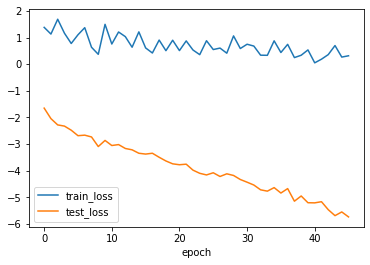

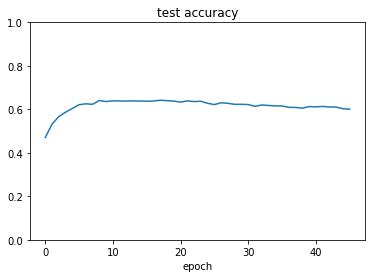

In [34]:
print(num_epoch)
print(history)
plt.figure()
plt.plot(range(len(history['train_loss'])), history['train_loss'], label='train_loss')
plt.plot(range(len(history['test_loss'])), history['test_loss'], label='test_loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig('loss2.png')

plt.figure()
plt.plot(range(len(history['test_acc'])), history['test_acc'])
plt.ylim(0, 1)
plt.title('test accuracy')
plt.xlabel('epoch')
plt.savefig('test_acc2.png')

In [36]:
net

myCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)